<a href="https://colab.research.google.com/github/marceloflores-soa/EA3-Colab/blob/main/SOA_Ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descripción Ejecicio 3
**Parte A:** Muestra undesarrollo basado en PyOpenCL para una conversión a escala de grises de una imagen ingresada por parámetro. 

**Parte B:** Muestra la utilización de algoritmos predictivos en Colab, usando la librería Pandas para el tratamiento de dataset y Scikit-learn para la ejecución de algoritmos predictivos.

# - Parte A - Aplicación de OpenCL

## Intalamos la librería PyOpenCL

In [75]:
!pip install pyopencl

## - Desarrollo en OpenCL

### Descripción

Realicé el desarrollo visto en clase para la transformación a escala de grises de una imagen, pero realizandolo sobre OpenCL. 

--2020-11-30 00:38:33--  https://virtualdreams.io/wp-content/uploads/2020/07/InNovaciones.png
Resolving virtualdreams.io (virtualdreams.io)... 35.237.145.177
Connecting to virtualdreams.io (virtualdreams.io)|35.237.145.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 830317 (811K) [image/png]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 810.86K  --.-KB/s    in 0.07s   

2020-11-30 00:38:33 (11.1 MB/s) - ‘imagen.jpg’ saved [830317/830317]


Tiempos: 
------------------------------------
Tiempo de conversión de imagen en GPU: 1.389 [ms]
Tiempo Total: 293.276 [ms]


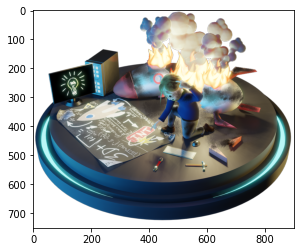

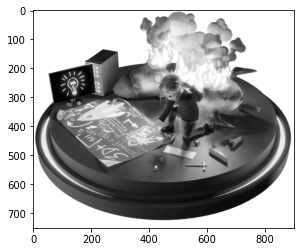

In [76]:
#@title Parámetros de ejecución { vertical-output: true }
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://virtualdreams.io/wp-content/uploads/2020/07/InNovaciones.png" #@param {type:"string"}


# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg

# --Importación de librerías
import pyopencl as cl
import numpy
import  matplotlib.pyplot as plt
from PIL import Image


# ---Inicialización de OpenCL
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

tiempo_total = datetime.now()

# ---Función kernel para convertir la imagen a escala de grises
prg = cl.Program(ctx, '''//CL//

__kernel void convert(
    read_only image2d_t src,
    write_only image2d_t dest
)
{

    const sampler_t sampler =  CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP_TO_EDGE | CLK_FILTER_NEAREST;
    int2 pos = (int2)(get_global_id(0), get_global_id(1));
    uint4 pix = read_imageui(src, sampler, pos);

    float luminance = 0.2126f * pix.x + 0.7152f * pix.y + 0.0722f * pix.z;
		pix.x = pix.y = pix.z = (uint)luminance;
   
    write_imageui(dest, pos, pix);
}
''').build()

# Cargamos la imagen
src_img = Image.open('imagen.jpg').convert('RGBA') 
src = numpy.array(src_img)
plt.figure()
imgplot=plt.imshow( src_img )
# Obtenemos los tamaños de la imagen
h = src.shape[0]
w = src.shape[1]

# construir una imagen 2D OpenCL a partir de la matriz numpy
src_buf = cl.image_from_array(ctx, src, 4)

# Construimos la imagen para trabajar en GPU
fmt = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)
dest_buf = cl.Image(ctx, cl.mem_flags.WRITE_ONLY, fmt, shape=(w, h))

# Ejecutamos la funcion Kernel
tiempo_img = datetime.now()

prg.convert(queue, (w, h), None, src_buf, dest_buf)

tiempo_img = datetime.now() - tiempo_img
# Copiamos los resultados desde GPU
dest = numpy.empty_like(src)
cl.enqueue_copy(queue, dest, dest_buf, origin=(0, 0), region=(w, h))

# Convertimos a imagen y mostramos por pantalla
dest_img = Image.fromarray(dest)
dest_img.save('result.png', "PNG")
plt.figure()
imgplot=plt.imshow( dest_img )

tiempo_total = datetime.now() - tiempo_total
print()
print( "Tiempos: " )
print( "------------------------------------")
print( "Tiempo de conversión de imagen en GPU:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )


### Tabla de pasos

 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de vectores desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  image_from_array() | Genera una imagen 2d en array.
**GPU**  |  cl.Image()      | Copia la imagen de CPU a GPU.
**GPU**  |  cl.enqueue_copy()    | Copia la imagen de GPU a CPU
CPU      |  SourceModule()        | Define el código del kernel. 
CPU      |  module.get_function() | Genera la función del kernel GPU.
**GPU**  |  prg.convert              | Ejecuta el kernel en GPU.
CPU      |  tiempo_en_ms()               | Transforma el tiempo en milisegundos.
CPU      |  plt.imshow()      | Muestra la imagen por pantalla.
CPU      |  print()               | Informo los resultados.

### Conclusión

Es notoria la velocidad con la que trabaja el paralelismo OpenCL, trabajando sobre cada pixel en paralelo y realizando la operación algoritmica. Por lo tanto, esta tecnología logra aprovechar los avances y potencia de los procesadores de las placas gráficas.

### Referencias Leídas

La investigación para la resolución de los problemas la obtuve de la documentación de PyOpenCl y diversas webs en la que se trataban ejemplos y comparaciones entre ejecuciones cpu y gpu.

http://doc-repository.niif.hu/486/1/Introduction_to_OpenCL_with_Examples.pdf

https://documen.tician.de/pyopencl/

# - PARTE B - Machine Learning

## Caso: Modelo de Predicción De Pago de Comisiones

El objetivo de este caso es construir un modelo que permita predecir si las casas vendidas pagan o no comisión, cuando su precio de venta sea superior a un determinado valor. 



## Análisis descriptivo del dataset

El set de entrenamiento a utilizar es **casas_entrenamiento.csv** el cual contiene información sobre 75.966 propiedades con su ubicación y características. En el archivo **Descripción Variables** se especifica la descripción de cada uno de sus atributos.

La variable target es **paga_comision**, que especifica si la venta de la propiedad paga o no comisión.

Descripción más detallada del dataset:
  https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_entrenamiento.csv

In [ ]:
# Librerias a importar
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline 

from IPython.display import Image

# Scikit-learn (sklearn) es una librería que implementa algunos algoritmos de Machine Learning y pre-procesamiento de datos.
from sklearn.tree import export_graphviz  

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics.scorer import make_scorer
from sklearn import metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Leemos el dataset de entrenamiento
dataset_entrenamiento='https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_entrenamiento.csv'
df = pd.read_csv(dataset_entrenamiento, sep =',', na_values = '.', parse_dates=["start_date","end_date","created_on"])
df['CLASE'] = df['paga_comision']
df.drop(["paga_comision"], axis=1, inplace=True)

df.head(5)

id  ...    CLASE
0  mSw0E1RIHFnJ1UjWmG2qtw==  ...  no paga
1  6xlrr/5ku0pbWrk03hLKrQ==  ...     paga
2  GNsHGUGRZGO0M2/JBkrt6Q==  ...  no paga
3  ec3j2TP5GfSGseuxOHdjSw==  ...  no paga
4  JeE2usc8v3Tfj/ZA/ifAEw==  ...  no paga

[5 rows x 21 columns]

In [ ]:
# Información estadística del dataset
df.describe()


lat           lon  ...  surface_total  surface_covered
count  64854.000000  64631.000000  ...   36459.000000     41669.000000
mean     -34.443771    -59.353761  ...     513.777037       238.344333
std        4.321409      2.832762  ...    2644.001657      2143.020380
min      -54.828087   -180.000000  ...      -2.000000        -5.000000
25%      -34.807490    -58.816697  ...     170.000000       120.000000
50%      -34.642029    -58.561035  ...     262.000000       175.000000
75%      -34.421031    -58.378182  ...     480.000000       250.000000
max       85.051129    -48.396729  ...  200000.000000    235000.000000

[8 rows x 8 columns]

Vemos que tanto la superficie total como superficie cubierta, tienen valores negativos en sus minimos.


no paga    76.42498
paga       23.57502
Name: CLASE, dtype: float64
no paga    58057
paga       17909
Name: CLASE, dtype: int64


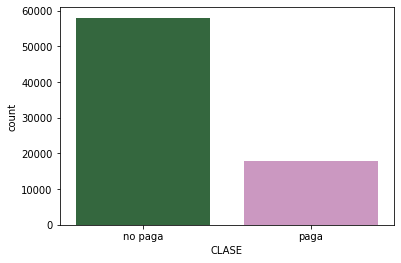

In [ ]:
# Veamos la distribución de la variable target 
print(df['CLASE'].value_counts(normalize = True)*100) # expresado en porcentajes
print(df['CLASE'].value_counts(normalize = False)) # expresado en nominal

sns.countplot(x='CLASE', data=df,  palette="cubehelix")

Podemos identificar que de las 75.966 propiedades, 58.057 no pagan comisión (valor 0) y 17.909 sí pagan (valor 1).


## Función de preparación de datos

In [ ]:
# FUNCION preparacion_de_datos (:parametros)
#   df_e            => Dataset de entrada a modificar
#   imputar_ouliers => Flag que indica si se deben imputar outliers o no
#   imputar_nulos   => Flag que indica si se deben imputar nulos o no

def preparacion_de_datos(df_e, imputar_ouliers, imputar_nulos):
  # Comenzamos haciendo una copia del dataset que la función recibe como parámetro de entrada
  df_s = copy.copy(df_e)

  # Quitamos los atributos
  df_s  = df_s.drop(['start_date','end_date','created_on','lat','lon','l3','l4','l5','l6','title'], axis=1) 	

   #---- IMPUTACIÓN DE OUTLIERS ----	
  if imputar_ouliers:
    print("TODO: Imputación de outliers.")

    # Función para calcular la media, con los parámetros:
    ## dff -> Dataframe a usar
    ## c   -> Columna a imputar
    ## min -> Límite inferior, si no aplica no se envía.
    ## max -> Límite superior, si no aplica no se envía.

    def calcular_media(dff, c, min=None, max=None):
      # Seteamos el mínimo y máximo, si viene por parámetro. Si no fueron informados, tomamos el actual del set de datos.
      minimo = dff[c].min() if min==None else min
      maximo = dff[c].max() if max==None else max
      
      # Filtramos los registros dentro del rango
      dff2 = dff[(dff[c]>=minimo) & (dff[c]<=maximo)]
      
      # Devolvemos la media
      return dff2[c].mean()

    # Imputamos la variable "SURFACE_TOTAL" que vimos necesitaba imputación de outliers superiores e inferiores a cero
    # Imputamos por un limite superior a 1000.
    # Imputamos por un limite inferior a 0.

    outlier_superior = df_s['surface_total'].mean() + 3*df_s['surface_total'].std()
    media_sin_outliers = calcular_media(df_s, 'surface_total', max=outlier_superior)
    df_s['surface_total'] = df_s.apply(lambda x: media_sin_outliers if x['surface_total']>outlier_superior else x['surface_total'], axis=1)
    df_s['surface_total'] = df_s.apply(lambda x: 0 if x['surface_total']<0 else x['surface_total'], axis=1)

    # Imputamos la variable "SURFACE_COVERED" que vimos necesitaba imputación de outliers superiores e inferiores a cero
    # Imputamos por un limite superior a +3.
    # Imputamos por un limite inferior a 0.

    outlier_superior = df_s['surface_covered'].mean() + 3*df_s['surface_covered'].std()
    media_sin_outliers = calcular_media(df_s, 'surface_covered', max=outlier_superior)
    df_s['surface_covered'] = df_s.apply(lambda x: media_sin_outliers if x['surface_covered']>outlier_superior else x['surface_covered'], axis=1)
    df_s['surface_covered'] = df_s.apply(lambda x: 0 if x['surface_covered']<0 else x['surface_covered'], axis=1)

    # Imputamos la variable "BATHROOMS" que vimos necesitaba imputación de outliers superiores
    # Imputamos por un limite superior a +3.
    outlier_superior = df_s['bathrooms'].mean() + 3*df_s['bathrooms'].std()
    media_sin_outliers = calcular_media(df_s, 'bathrooms', max=outlier_superior)
    df_s['bathrooms'] = df_s.apply(lambda x: media_sin_outliers if x['bathrooms']>outlier_superior else x['bathrooms'], axis=1)

    # Imputamos la variable "BEDROOMS" que vimos necesitaba imputación de outliers superiores
    # Imputamos por un limite superior a +3.
    outlier_superior = df_s['bedrooms'].mean() + 3*df_s['bedrooms'].std()
    media_sin_outliers = calcular_media(df_s, 'bedrooms', max=outlier_superior)
    df_s['bedrooms'] = df_s.apply(lambda x: media_sin_outliers if x['bedrooms']>outlier_superior else x['bedrooms'], axis=1)


  #---- FEATURE ENGINEERING ----

  print("TODO: Creación de nuevas variables.")

  # Porcentaje de cobertura 
  df_s['c_cobertura_propiedad'] = list(map(lambda surface_covered, surface_total:
                                      round( ( (surface_covered or 0)/surface_total if ( (surface_total or 0) != 0 ) else 0 ), 2) ,
                                      df_s['surface_covered'],
                                      df_s['surface_total']))

  # Porcentaje de habitaciones que son baños  
  df_s['c_hab_baño'] = list(map(lambda bathrooms, rooms:
                                      round( ( (bathrooms or 0)/rooms if ( (rooms or 0) != 0 ) else 0 ), 2) ,
                                      df_s['bathrooms'],
                                      df_s['rooms']))
  

  #---- TRATAMIENTO DE VALORES NULOS ----
  if imputar_nulos:
    print("TODO: Imputación de valores nulos.")

    # A la variable l1, le relleno los nulos con una nueva categoria Null
    df_s["l1"] = df_s["l1"].fillna('Null')

    # A la variable l2, le relleno los nulos con una nueva categoria Null
    df_s["l2"] = df_s["l2"].fillna('Null')

    # A la variable l3, le relleno los nulos con una nueva categoria Null
    #df_s["l3"] = df_s["l3"].fillna('Null')

    # A la variable price_period, le relleno los nulos con una nueva categoria Null
    df_s["price_period"] = df_s["price_period"].fillna('Null')

    # A la variable surface_total, le relleno los nulos con la media
    df_s['surface_total']  = df_s.apply(lambda x: calcular_media(df_s, 'surface_total')          if x['surface_total']==0        else x['surface_total'],        axis=1)

    # A la variable surface_covered, le relleno los nulos con la media
    df_s['surface_covered']  = df_s.apply(lambda x: calcular_media(df_s, 'surface_covered')          if x['surface_covered']==0        else x['surface_covered'],        axis=1)

    # Al resto los fuerzo 0
    df_s[df_s==np.inf]=np.nan
    df_s.fillna(0, inplace=True)

  # Convertimos la variable clase en un numérico con 0 o 1
  #df_s['CLASE'] = list(map(lambda clase: 1 if (clase == 'Paga') else 0, df_s['CLASE']))

  # Encodeamos todos los atributos categóricos como booleanos con la función DictVectorizer
  #vec = DictVectorizer(sparse=False, dtype=int)
  #vec.fit_transform(df_s)

  return df_s

In [ ]:
# Ejecutamos la función de preparacion de datos.
# Indicando que si queremos imputar ouliers y si queremos imputar nulos
# Este el primer paso que debemos realizar para tener todas las variables a utilizar.
# Quitamos los atributos
df  = df.drop(['id'], axis=1) 	

df = preparacion_de_datos(df, True, True)

df.head()

TODO: Imputación de outliers.
TODO: Creación de nuevas variables.
TODO: Imputación de valores nulos.


ad_type         l1  ... c_cobertura_propiedad  c_hab_baño
0  Propiedad  Argentina  ...                  0.00        0.75
1  Propiedad  Argentina  ...                  0.86        0.00
2  Propiedad  Argentina  ...                  1.00        0.00
3  Propiedad  Argentina  ...                  0.00        0.00
4  Propiedad  Argentina  ...                  0.00        0.00

[5 rows x 12 columns]

In [ ]:
print(df.shape)

(75966, 12)


In [ ]:
# Dejamos en el dataset de entrenamiento todas las variables, excepto la CLASE.

X  = pd.get_dummies(df.drop(['CLASE'], axis=1))
atributos = X.columns

# Encodeamos las etiquetas usando LabelEncoder
# Convertimos la variable objetivo en una variable booleana de valores 0 o 1 para simplificar los cálculos

le = LabelEncoder()
y = le.fit_transform(df['CLASE'])


# Dividimos el dataset en entrenamiento y prueba (60% para training y 40% para testing)
# Dividimos X e y con la funcion train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

print(y_train.shape)


(53176,)


In [ ]:
print(X_train.shape)
X_train.head(5)

(53176, 53)


rooms  bedrooms  ...  price_period_Mensual  price_period_Null
59930    0.0       4.0  ...                     0                  1
47389    0.0       0.0  ...                     0                  1
32736    3.0       0.0  ...                     0                  1
75219    4.0       3.0  ...                     1                  0
73199    4.0       3.0  ...                     1                  0

[5 rows x 53 columns]

## - Construcción del modelo predictivo con árbol de desición

In [ ]:
# Ajustamos un árbol de clasificación con max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

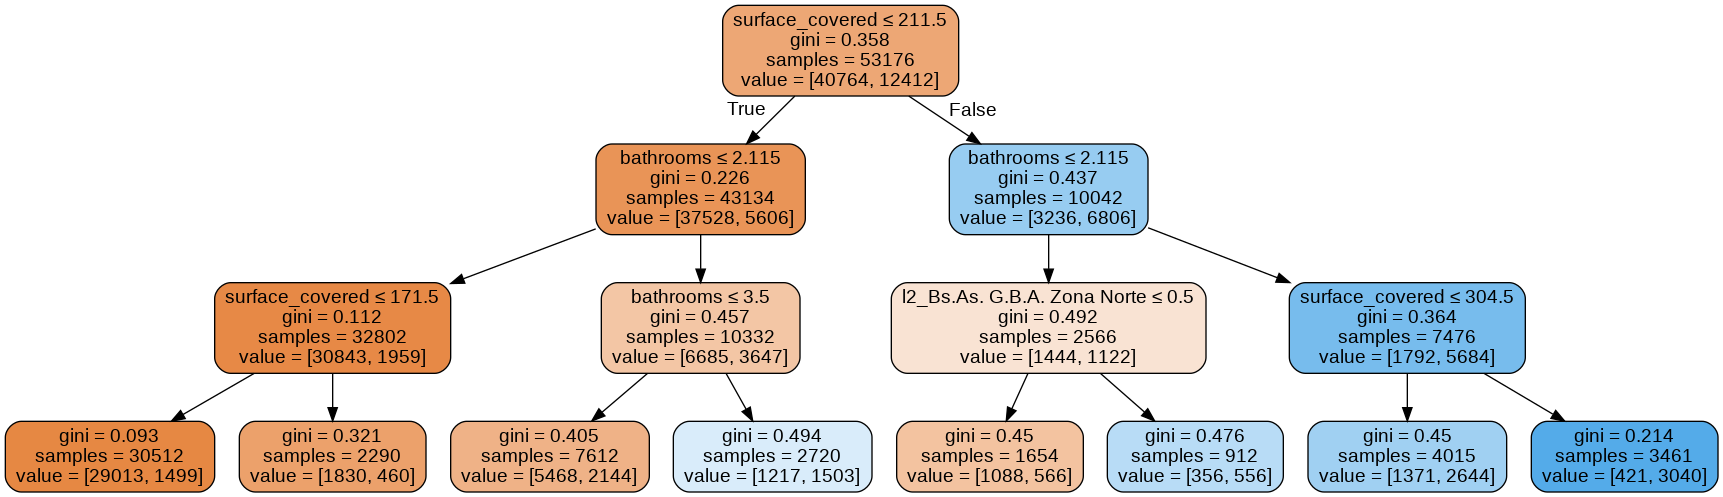

In [ ]:
# Visualizamos el árbol de decisión usando graphviz
dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

*Lectura del árbol de decisión generado

Interpretación de Resultados


surface_covered > 211.5 -> bathrooms > 2.115 -> surface_covered > 304.5 => P('Paga') = 3040 / 3461 = 87.8%

surface_covered > 211.5 -> bathrooms <= 2.115 -> l2 = Zona Norte  => P('Paga') = 556 / 912 = 60.9%

*Curva ROC

AUC - Area Under the Curve - Área Bajo la Curva: 0.856753494735688


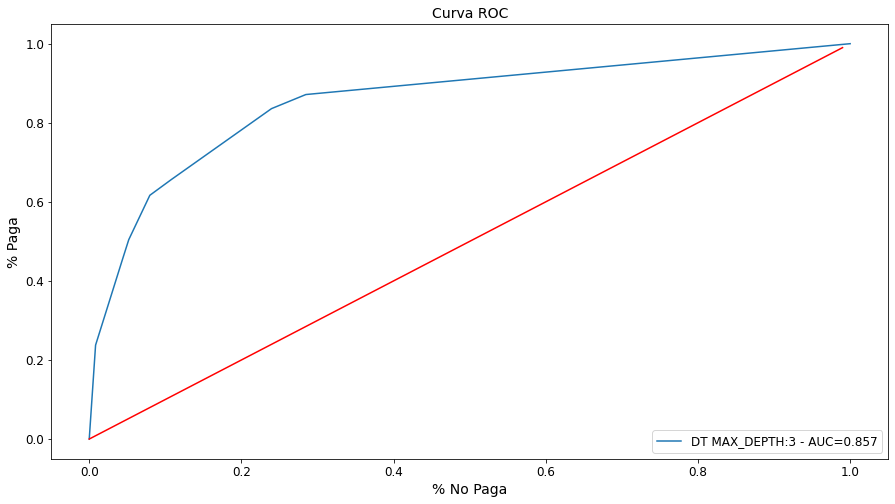

In [ ]:
plt.figure(figsize=(15, 8))

y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))

# Graficamos la curva roc del arbol
plt.plot(fpr,tpr,label="DT MAX_DEPTH:3 - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

*Matriz de Confusión del Modelo y Errores de Predicción

In [ ]:
y_pred = treeclf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

pred_no paga  pred_paga
no paga         15916       1377
paga             2108       3389

Métricas:
- Exactitud (Accuracy) = 19.305 / 22.790 = 84.70%                
- Error de Predicción = 1 - Exactitud = 15.30%
- Precisión = 3.389 / 4.766 = 71.10%
- Sensibilidad (Recall) = 3.389 / 5.497 = 61.65%

In [ ]:
# Reporte del clasificador
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     17293
           1       0.71      0.62      0.66      5497

    accuracy                           0.85     22790
   macro avg       0.80      0.77      0.78     22790
weighted avg       0.84      0.85      0.84     22790



-  Función de Ganancia y Probabilidad de Corte


Esta función de ganancia consiste en **sumar 100 puntos por cada acierto** y **restar 50 punto por cada fallo**, para definir una métrica que podamos usar para la optimización del modelo. Estos puntajes nos definen una **probabilidad de corte** que determinan cuáles de las observaciones serán consideradas como positivas en el hecho que paga comisión. 

- universo_total = comision('Paga') + comision('No paga')

- ganancia = **100** * comision('Paga') - **50** * comision('No paga')

**( * )** Cuando se haga referencia a **cosision('Paga')** se refiere a la cantidad (#) de observaciones cuya clase es Paga (Paga comisión), analogamente aplica para **comision('No paga')**.	

Si descomponemos el 100 como la resta (150-50), también se podría escribir como:

- ganancia = **150** * comision('Paga') - **50** * comision('paga') - **50** * dias('No paga')

Si trabajamos un poco esta función de ganancia, buscando que la ganancia generada sea **mayor a 0**, podemos calcular la **probabilidad de corte**, si tenemos que ganancia > 0, entonces:
- 150 * comision('Paga') - 50 * comision('Paga') - 50 * comision('No paga')  **>** 0
- 150 * comision('Paga') - 50 * ( comision('Paga') + comision('No paga') )  **>** 0
- 150 * comision('Paga') **>** 50 * ( comision('Paga') + comision('No paga') ))

- ( comision('Paga') / ( comision('Paga') + comision('No paga') ) ) **>** 50 / 150

- **PROB('Paga') > 0.33**

Esta función nos indica que la **probabilidad de corte es 0.33** aunque uno puede modificar ese valor para mejorar el modelo.

In [ ]:
prob_corte = float(0.33) # probabilidad de corte calculada 

#Definimos la función de ganancia a utilizar para el scoring en la búsqueda:
def funcion_ganancia(clf, X, y_true):
    y_prob_comision = clf.predict_proba(X)[:, 1]
    
    ganancia = sum([(100 if y_true[i] > 0 else -50) 
                    if y_prob_comision[i]  > prob_corte
                    else 0 
                    for i in range(len(y_prob_comision))])
    
    return ganancia

-  Construcción del modelo usando GridSearchCV con optimización de hiperparámetros


In [ ]:
# Definimos los parametros a evaluar:

PARAMETROS = {'max_depth':[5, 8, 10, 12, 15, 20], 
              'max_features':[15, 20, 25, 30, 35, 40], 
              'max_leaf_nodes':[30, 50, 90, 100, 120, 150], 
              'min_samples_leaf':[50, 100, 150, 200, 300],
              'min_samples_split':[100, 200, 300, 400, 600]}

k_n_jobs = 2 # numero de iteraciones definidas

# Hacemos la búsqueda con GridSearchCV

model = DecisionTreeClassifier(random_state=1)  # modelo de árbol de decision, podría ser cualquier otro o iterar una lista de modelos para probar y sus parametros
gs = GridSearchCV(model, 
                  PARAMETROS, 
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1)
gs.fit(X_train, y_train)

# Mostramos los mejores resultados obtenidos

print(gs.best_estimator_)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   26.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   49.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:  8.2min
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed: 12.2min
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed: 16.7mi

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=40, max_leaf_nodes=150,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


In [ ]:
print('Puntaje del modelo en CV: {:.2f}'.format(gs.best_score_))
print('Puntaje del modelo en Testing: {:.2f}'.format(funcion_ganancia(gs.best_estimator_, X_test, y_test)))

Puntaje del modelo en CV: 232583.33
Puntaje del modelo en Testing: 317000.00


* Interpretación de resultados

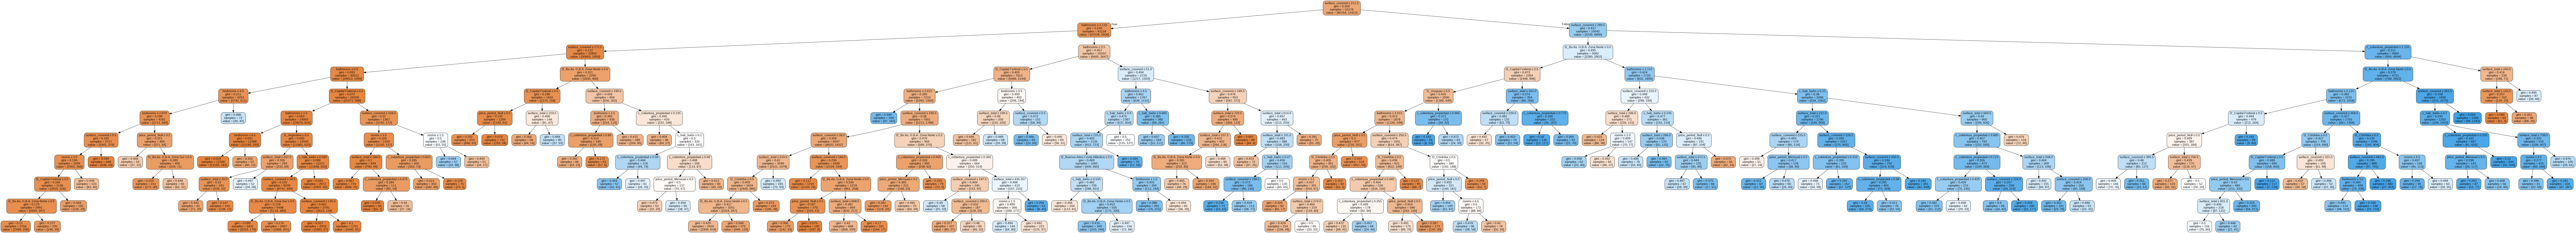

In [ ]:
# Visualizamos el mejor árbol de decisión generado usando graphviz
dot_data=export_graphviz(gs.best_estimator_, 
                         out_file=None,
                         feature_names=X.columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())  

* Guardamos el árbol


In [ ]:
# Como primer paso, vamos a probar todas las combinaciones de parámetros
# y vamos a guardar los resultados de cada árbol en la lista "resultados"
resultados = []

# Recorremos las combinaciones de parámetros y guardamos el árbol entrenado, parámetros y la predicción
for p in gs.cv_results_['params']:
  treeclf2 = DecisionTreeClassifier(max_depth= p['max_depth'],
                                    max_features= p['max_features'],
                                    max_leaf_nodes= p['max_leaf_nodes'],
                                    min_samples_split= p['min_samples_split'],
                                    random_state=1)
  treeclf2.fit(X_train, y_train)
  y_pred_proba = treeclf2.predict_proba(X_test)[::,1]
  
  # Guardamos el árbol, la predicción y los parámetros de cada ejecucion
  resultados.append({"árbol": copy.copy(treeclf2), "prediccion":copy.copy(y_pred_proba), "parámetros":copy.copy(p)})

* Curva ROC de cada árbol

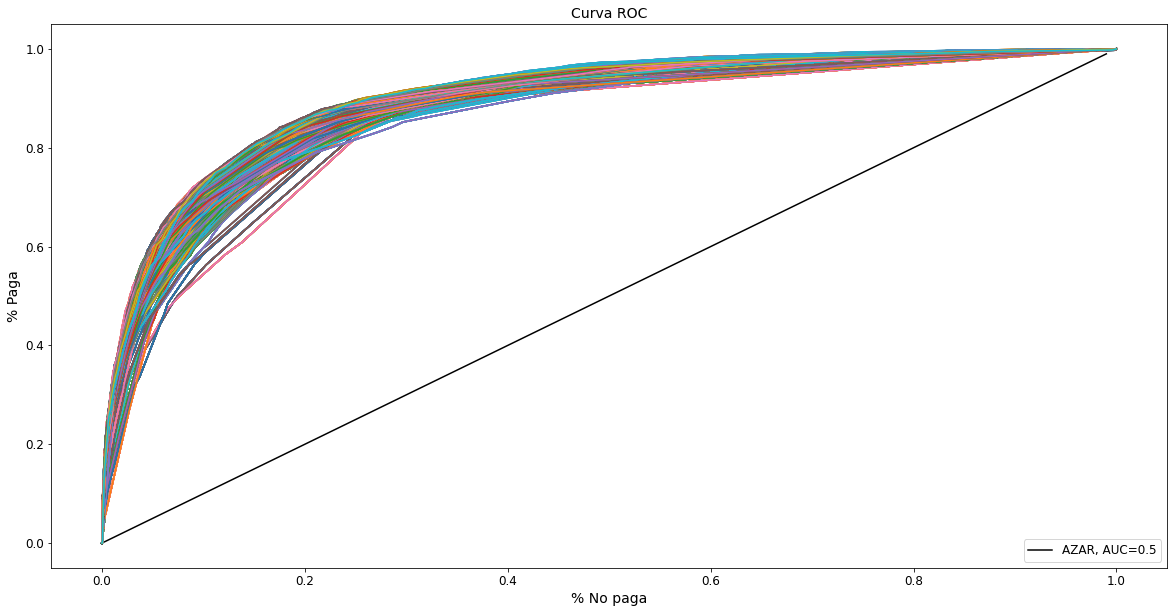

In [ ]:
# Graficamos la curva ROC del arbol de cada iteracion
def graficarCurvaRoc(arbol):
  # Calculamos la probabilidad predicha
  y_pred_proba = r['prediccion']
  
  # Calculamos los valores de la curva ROC para graficar
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
  
  # Calculamos el Area Bajo la Curva (AUC) y la guardamos
  auc = metrics.roc_auc_score(y_test, y_pred_proba)
  r['auc'] = auc

  # Graficamos
  plt.plot(fpr,tpr) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)

# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% No paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="black")

# Para cada árbol probado (en la variable resultados) graficamos la curva ROC
for r in resultados:
    graficarCurvaRoc(r)

# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

* Matriz de confusión

In [ ]:
# Calculamos y mostramos la matriz de confusión del modelo
y_pred = gs.best_estimator_.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

pred_no paga  pred_paga
no paga         16303        990
paga             2101       3396

In [ ]:
# Reporte del clasificador
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     17293
           1       0.77      0.62      0.69      5497

    accuracy                           0.86     22790
   macro avg       0.83      0.78      0.80     22790
weighted avg       0.86      0.86      0.86     22790



- Aplicando el modelo a datos nuevos

Ahora podemos aplicar el modelo generado a los datos nuevos donde no conocemos la clase para predecir el futuro. El set de prueba con los nuevos datos a utilizar es **casas_predecir.csv**.

In [ ]:
# Leemos el dataset de aplicacion, para predecir sobre propiedades.
dataset_aplicacion='https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_predecir.csv'
df_apply = pd.read_csv(dataset_aplicacion, sep =',', na_values = '.', parse_dates=["start_date","end_date","created_on"])

# Para estandarizar el análisis, llamaremos variable "CLASE" a la variable target
df_apply['CLASE'] = df_apply['paga_comision']
df_apply.drop(["paga_comision"], axis=1, inplace=True)

# Seteamos el id.
df_apply.set_index( 'id', inplace=True)

# Siempre el primer paso es ejecutar la función de preparacion de datos que construimos
df_apply = preparacion_de_datos(df_apply, True, True)

# Borramos la CLASE, ya que ambos son constantes, en este caso.
df_apply = df_apply.drop(['CLASE'], axis=1)

# Veamos como quedó el dataset
df_apply.head(10)


TODO: Imputación de outliers.
TODO: Creación de nuevas variables.
TODO: Imputación de valores nulos.


ad_type         l1  ... surface_covered  price_period
0  Propiedad  Argentina  ...           150.0       Mensual
1  Propiedad  Argentina  ...             0.0          Null
2  Propiedad  Argentina  ...           120.0       Mensual
3  Propiedad  Argentina  ...           152.0          Null
4  Propiedad  Argentina  ...             0.0          Null
5  Propiedad  Argentina  ...             0.0          Null
6  Propiedad  Argentina  ...             0.0          Null
7  Propiedad  Argentina  ...           160.0       Mensual
8  Propiedad  Argentina  ...           124.0       Mensual
9  Propiedad  Argentina  ...           150.0       Mensual

[10 rows x 9 columns]

In [ ]:
# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo). 
X_apply = pd.get_dummies(df_apply)
atributos = X_apply.columns

# Aplicamos la predicción al nuevo dataset
scores = gs.best_estimator_.predict_proba(X_apply)

# Agregamos al dataset la probabilidad de lluvia predicha con el modelo
df_result = copy.copy(df_apply)
df_result['PROB'] = scores[:,1]

# Veamos como quedó:
df_result.sort_values(by='PROB', ascending=False).head(5)

ad_type         l1  ... price_period      PROB
39368  Propiedad  Argentina  ...         Null  0.969309
16796  Propiedad  Argentina  ...      Mensual  0.969309
46203  Propiedad  Argentina  ...      Mensual  0.969309
44890  Propiedad  Argentina  ...      Mensual  0.969309
28288  Propiedad  Argentina  ...         Null  0.969309

[5 rows x 10 columns]

- Resultado Final

In [ ]:
from google.colab import files
dataset_entrega='casas_entrega.csv'

# Entregamos sólo las observaciones donde predecimos que va a llover
df_entregar = df_result[df_result.PROB > prob_corte]
df_entregar.to_csv(path_or_buf=dataset_entrega, sep=",", na_rep='.')
files.download(dataset_entrega)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>